<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Notebook 1: Load and View Data</h3> 

I been writing comments in <font color='red'><b>red</b></font> and rewordings in <font color='blue'><b>blue</b></font>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<p>Analyzing neuron morphology data begins with accessing it--and understanding how the data is structured. This first notebook will provide and example of loading, examining, and visualizing a neuron <bold>skeleton</bold> in 2D and 3D.
</div>

<font color='red'><b> Also maybe mention that we will work with two different types of neuron morphology data. The first part of this tutorial focuses on EM neurons and the second part on LM neurons. Here's a rewording... <font><b>


<font color='blue'><b> Analyzing neuron morphology data begins with accessing it--and understanding how the data is structured. This notebook provides an example of how to load, examine, and visualize a neuron skeleton in both 2D and 3D. We introduce these
 tools by exploring two different datasets containing neurons that were imaged with Electron Microscopy (EM) and Lightsheet Microscopy (LM).<font><b> 

In [1]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

In [2]:
import k3d
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import cloudvolume

<font color='red'><b> Put all of these imports in one box. <font><b>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
<h2> Load the Skeleton Data from the precomputed format </h2>

<p> <a href="https://github.com/seung-lab/cloud-volume">CloudVolume</a> is a serverless Python client for random access reading and writing of Neuroglancer volumes in <a href="https://github.com/google/neuroglancer/tree/master/src/neuroglancer/datasource/precomputed">"Precomputed"</a> format, a set of representations for arbitrarily large volumetric images, meshes, and skeletons. 

<p> We will use cloudvolume to load precomputed skeletons from Electron Microscopy (EM) data and Lightsheet Microscopy (LM) data.
    
</div>

<font color='red'><b>Do they already know what neuroglancer is? Otherwise it would be nice to add one sentence that explains that neuroglancer is a tool used to visualize neuron morphology data and our data must be in the precomputed format to be read into neuroglancer. </b></font>


<font color='blue'><b> Neuroglancer is a web-based application for visualizing large-scale biological images and neuron morphology datasets. This tool requires that the data is stored as a "Precomputed" file, which is a format designed for large volumetric images, meshes, and skeletons. Our neuron data is stored in this precomputed skeleton format and we will use a python library called CloudVolume to load the neurons from both the Electron Microscopy (EM) and Lightsheet Microscopy (LM) datasets.</b></font>


In [4]:
#EM Data
input_directory = "precomputed://gs://allen_neuroglancer_ccf/em_minnie65_v661"
skeleton_id = 864691135591041291
cv_obj = cloudvolume.CloudVolume(input_directory, use_https = True) # Initialize cloud volume
cv_sk = cv_obj.skeleton.get(skeleton_id) #load an example skeleton

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>The precomputed skeleton is a simplified representation of a neuron, with centerlines through the tree-like structure of a neuron defined by their `vertices` and `edges`
    
<p> (Add Schematic)

</div>

<font color='red'><b> It could be nice to mention that the precomputed format also stores additional features.</b></font>


<font color='blue'><b> A precomputed skeleton is a simplified representation of a neuron where its shape is captured by a tree-like structure that passes through the center of the neuron. More specificy, a precomputed skeleton stores a neuron as a graph with vertices and edges in addition to a collection of node-level attributes that capture morphological and anatomical information about the neuron.</b></font>

<font color='blue'><b> Note: Observe that many attributes such as "radius" and "compartment" have the same shape as "vertices "</b></font>

In [5]:
print("This is a precomputed skeleton of an EM neuron...\n")
print(cv_sk)

This is a precomputed skeleton of an EM neuron...

Skeleton(segid=864691135591041291, vertices=(shape=9154, float32), edges=(shape=9153, uint32), radius=(9154, float32), compartment=(9154, float32), presyn_counts=(9154, float32), postsyn_counts=(9154, float32), presyn_size=(9154, float32), postsyn_size=(9154, float32), space='physical' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>Each vertex may also be associated with one or more other properties, including:
<ul>
    <li> <code>radius</code>: the cable radius of the segment
    <li> <code>compartment</code>: whether the segment belongs to the axon, dendrite, or soma. Also called the <i>label</i> or <i>type</i> of the vertex.
</ul>

<p>We will see these properties rendered later in this notebook, and discuss the other properties in the following notebooks

</div>

<font color='red'><b> Why not just define all of the attributes that we see printed above </b></font>

<font color='red'><b> The definition of "radius" isn't great since it uses the word that we're defining. What about "the thickness of the neuron at a given vertex" </b></font>

<font color='red'><b> Are there really no xyz coordinates that are stored? Otherwise, how are we generating these plots? </b></font>

<font color='red'><b> We should mention that the compartments are coded with a numerical key i.e. soma: 1, etc. I know that we define this in the other notebook, but the compartments are used in this notebook. </b></font>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Convert precomputed skeleton to a meshwork skeleton </h2>
    
<p><a href="https://github.com/CAVEconnectome/MeshParty/">MeshPary</a> is a package that simplifies the analysis of morphological properties of neurons. A <code>meshwork</code> object can include the 3D meshes of a reconstructed neuron, the skeleton structure of that neuron, and related annotations such as synapse properties and myelination.

<p>We will use MeshParty's <code>skeleton</code> object to help plot and analyze the precomputed skeletons.

    
</div>

In [6]:
from meshparty import skeleton

In [7]:
sk = skeleton.Skeleton(cv_sk.vertices, 
                       cv_sk.edges, 
                       vertex_properties={'radius': cv_sk.radius,
                                          'compartment': cv_sk.compartment},  
                       root = len(cv_sk.edges), # EM: when the final edge is root
                       remove_zero_length_edges = False)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Plot Skeleton in 2D </h2>
    
<p> <a href="https://github.com/AllenInstitute/skeleton_plot">Skeleton-plot</a> provides some handy utilities for plotting meshwork skeletons, including:
<ul>
<li> specifying the 2D orientation
<li> annotating somas
<li> labeling compartments by color
    
</div>

In [8]:
import skeleton_plot as skelplot

(7726840.5, 8438740.0, 1497648.0, 675351.375)

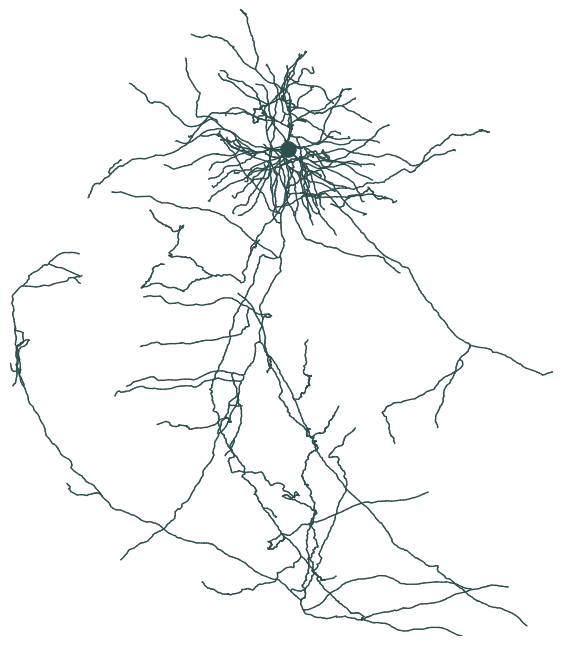

In [9]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    plot_soma = True,
    invert_y = True,
    x="x",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Here we have the example neuron rendered in 2D. You can change the plot properties such as: line width, axis orientation, and axes appearance. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  Try changing the project from x-y to y-z to see how that changes your perception of the 3D structure
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Add radius and compartment labels </h2>
    
<p> To get a more accurate understanding of the neuron's morphology, you can pull in information about the radius and compartment labels into your visualization. 
    
<p>Here the axon is colored black, basal dendrites 'firebrick' red, apical dendrites 'salmon' orange, and the soma a green 'olive'.
    
</div>

<font color='red'><b> Change title to "Neuron with radius and compartments"<font><b>
    
<font color='red'><b> Is it possible to add a legend? <font><b>

(7726840.5, 8438740.0, 1497648.0, 675351.375)

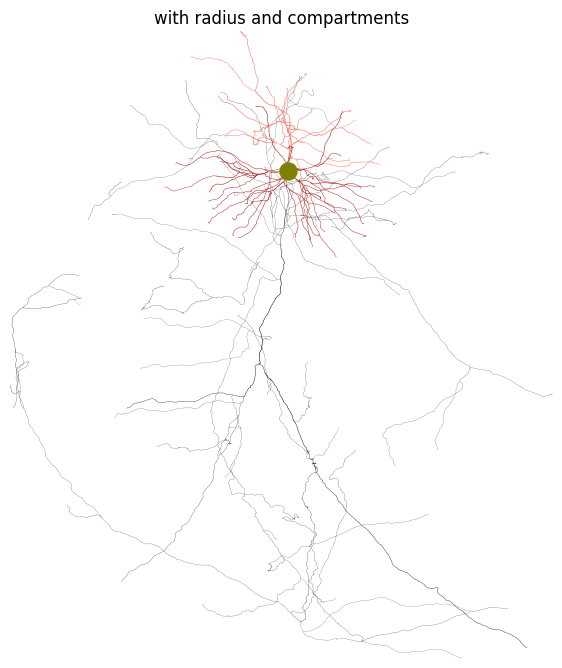

In [10]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="with radius and compartments",
    line_width=1,
    plot_soma=True,
    soma_size = 150,
    pull_radius=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="x",
    y="y",
    skel_color_map = { 3: "firebrick",4: "salmon",2: "black",1: "olive" },
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.2:</b>  To see more plotting features, enter <code>skelplot.plot_tools.plot_skel?</code> to see the function documentation
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Plot skeleton in 3D (with k3d) </h3>

<p> Of course, neurons are three-dimensional structures, and so we also want to inspect their morphology in 3D. For this, we will use the interactive 3D rendering package, k3d.
    
</div>

<font color='blue'><b> Change "inspect" to "visualize" <font><b>

In [11]:
# Define plotting functions to turn a skeleton into line objects
def plot_graphs(graphs, plot, color = None):
    for i, g in enumerate(graphs):
        g_lines = graph_to_lines(g,color)
        plot += g_lines
        

def graph_to_lines(g,color=None):
    # Extract vertex positions
    g_verts = g.vertices
    
    # Pairs of indices into the vertex array are edges
    g_inds = g.edges
    
    # Could add iteration here to plot compartments in different colors
    
    g_lines = k3d.factory.lines(g_verts, g_inds, indices_type='segment', width=1, shader='simple')
    return g_lines

In [12]:
plot = k3d.plot()
plot_graphs([sk], plot)
plot.display()

/opt/conda/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Exercises </h2>
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><h3>Load an LM cell</h3>
</div>

In [13]:
#Example Cell to Load:

input_directory = "precomputed://s3://aind-open-data/exaSPIM_609281_2022-11-03_13-49-18_reconstructions/precomputed"
skeleton_id = 1
cv_obj = cloudvolume.CloudVolume(input_directory) # Initialize cloud volume
cv_sk = cv_obj.skeleton.get(skeleton_id) #load an example skeleton


sk = skeleton.Skeleton(cv_sk.vertices, 
                       cv_sk.edges, 
                       vertex_properties={'radius': cv_sk.radius,
                                          'compartment': cv_sk.compartment}, 
                       root = 0, 
                       # root = len(cv_sk.edges), # when the final edge is root
                       remove_zero_length_edges = False)


NoCredentialsError: Unable to locate credentials

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.1:</b>  Look at the vertex_properties of the skeleton object. How many unique compartment types are there?

<p>(Note that the LM neurons do not have radii associated with vertices and are set to 1)
</div>

<font color='red'><b> The LM neurons can have a radius associated with them, is that something we should add? The neurons that were reconstructed by using the google fragments probably have a radius. Maybe we should use those?  <font><b>
    
<font color='red'><b> Exercise: What node-level attributes does the EM neuron have that the LM neuron lacks? Why do you think these attributes are absent in the LM neuron. (Hint: it is related to the resolution of the microscope).
<font><b>

In [ ]:
#Answer

print(sk.vertex_properties)
print(np.unique(sk.vertex_properties['compartment']))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2:</b>  View it in 2D
</div>

In [ ]:
#Answer

f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    plot_soma = True,
    invert_y = True,
    x="x",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')



<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.3:</b>  View it in 3D
</div>

In [ ]:
#Answer
plot = k3d.plot()
plot_graphs([sk], plot)
plot.display()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4:</b>  View it with colored compartments
</div>

In [ ]:
#Answer
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="with radius and compartments",
    line_width=1,
    plot_soma=True,
    soma_size = 150,
    pull_radius=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="x",
    y="y",
    skel_color_map = { 3: "firebrick",4: "salmon",2: "black",1: "olive" },
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.5:</b>  How would you change the 3D plot to add 1) the soma point and 2) colored lines for each compartment like is rendered in 2D?
</div>

In [ ]:
# (HINT: see the definition of the skeleton meshwork for information about the soma 'root')
# (HINT: dig into the script-defined functions for coercing the skeleton object into a k3d graph object)
# TODO: Optimal Answer

<font color='red'><b> General Comments <font><b> 
    
<font color='red'><b> --> The skeletons are stored as graphs, but we don't explicitly say that a skeleton is graph.
It could be helpful to mention this, especially for students that are familiar with graphs -- which
I would guess is most of them. <font><b> 

<font color='red'><b> --> We should mention that each node as an xyz cordinate, especially since we're generating plots
of these neurons and computing path lengths. The term for this in the literature is a "Geometric
Graph", it could be worth mentioning since geometric deep learning is rapidly growing field of research.<font><b> 

<font color='red'><b> --> LM neurons can have a radius. I'll look into extracting the radius for the LM datasets.<font><b> 